# <font color='blue'>Get data</font> 

## Create connectome matrix

Set up the folder that contains raw data.

In [1]:
task = 'Rest'

Store all values above diagonal of connectome matices in matrix *c*.

In [2]:
files = list.files(paste('Data/Connectome/', task,'/Raw', sep = ''))
ids_length = 6
c = c()
c_ids = c()

for(file in files){
    data = read.csv(paste('Data/Connectome/', task, '/Raw/', file, sep = ''), header = FALSE)
    c_ids = append(c_ids, substr(file, 1, ids_length))
    colnames(data) = NULL
    c = rbind(c, data[upper.tri(data, diag = FALSE)])
}
n = ncol(data)

In [3]:
c_names = matrix(paste('c', rep(1:n, n), rep(1:n, rep(n, n)), sep = '_'), n, n)
c_names = c_names[upper.tri(c_names, diag = FALSE)]
rownames(c) = c_ids
colnames(c) = c_names

In [4]:
write.csv(c, file = paste('Data/Connectome/', task, '/c.csv', sep = ''), row.names = TRUE)  

## Create questionnaire matrix

In [5]:
data = read.table(paste('Data/Questionnaire/questionnaire.csv', sep = ''), sep = ',', header = TRUE, row.names = 1)

Save gender+motion information in *gender_motion.csv*.

In [6]:
gender = subset(data, select = c(Gender))
write.csv(gender, file = paste('Data/Questionnaire/gender.csv', sep = ''), row.names = TRUE)  

Save family information in *family.csv*.

In [7]:
family = subset(data, select = c(Family_ID))
write.csv(family, file = paste('Data/Questionnaire/family.csv', sep = ''), row.names = TRUE)  

Save questionnaire in *q.csv*.

In [8]:
q = subset(data, select = -c(Family_ID, Gender, Age_in_Yrs, motion_rest, motion_emo))
write.csv(q, file = paste('Data/Questionnaire/q.csv', sep = ''), row.names = TRUE)  

# <font color='blue'>Adjust data for gender effect </font>

In [9]:
library(dummies)

dummies-1.5.6 provided by Decision Patterns



Create dummy variables for gender.

In [10]:
gender = dummy.data.frame(gender)

Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"

## Adjust questionnaires for gender effect

Run regression *q~gender*.

In [11]:
gender = as.matrix(gender[rownames(q),])
LM = lm(as.matrix(q) ~ gender + 0)
q_adj = LM$residuals

Save residuals as well as regression coefficients.

In [12]:
write.csv(data.frame('Gender' = c('F', 'M'), LM$coef), file = paste('Data/Questionnaire/Adjust/beta_adj_gender.csv', sep = ''), row.names = FALSE)
write.csv(q_adj, file = paste('Data/Questionnaire/Adjust/q_adj_gender.csv', sep = ''), row.names = TRUE)  

## Adjust connectome data for gender effect

Run regression *c~gender*.

In [13]:
gender = as.matrix(gender[rownames(c),])
beta_hat = solve(t(gender) %*% gender) %*% (t(gender) %*% as.matrix(c))
c_hat = gender %*% beta_hat
c_adj = c - c_hat

Save residuals as well as regression coefficients.

In [15]:
write.csv(data.frame('Gender' = c('F', 'M'), beta_hat), file = paste('Data/Connectome/', task, '/Adjust/beta_adj_gender.csv', sep = ''), row.names = FALSE)
write.csv(c_adj, file = paste('Data/Connectome/', task, '/Adjust/c_adj_gender.csv', sep = ''), row.names = TRUE)

# <font color='blue'>Block CV</font>  

## Set train and test split

In [16]:
set.seed(0)
n_fam = length(unique(family$Family_ID))
labels = sample(n_fam)
family$Family_ID = as.numeric(factor(family$Family_ID, labels = sample(n_fam)))

In [17]:
family_test = subset(family, Family_ID/n_fam <= 0.2) 
family_train = subset(family, Family_ID/n_fam > 0.2) 

Save test ids.

In [18]:
subject_test = rownames(family_test)
write.csv(data.frame('Subject' = subject_test), file = paste('Data/subject_test.csv', sep = ''), row.names = FALSE)

## Set CV split

In [19]:
K = 10
split_train = family_train$Family_ID%%K + 1

Save train ids as well as split.

In [20]:
subject_train = rownames(family_train)
write.csv(data.frame('Subject' = subject_train, 'Split' = split_train), file = paste('Data/subject_train.csv', sep = ''), row.names = FALSE)

Set train and test sets

In [21]:
c_train = as.matrix(c_adj[as.character(subject_train),])
c_test = as.matrix(c_adj[as.character(subject_test),])

In [22]:
q_train = as.matrix(q_adj[as.character(subject_train),])
q_test = as.matrix(q_adj[as.character(subject_test),])

# <font color='blue'>Cross-Validated RCCA</font> 

In [23]:
library(ggplot2)
library(gridExtra)
library(grid)
library(matrixStats)
library(fda)

Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'fda' was built under R version 3.6.3"Loading required package: Matrix

Attaching package: 'fda'

The following object is masked from 'package:graphics':

    matplot



Splits the data in train (90%) and test (10%) at random and returns the canonical correlations for training and test data.
Calculate 1SD confidence intervals for train and test canonical correlations.

In [24]:
RCCA_CV = function(X, Y, lambda1s, split){
    K = max(split)
    ncomp = min(ncol(X), ncol(Y))
    n = nrow(X)
    cor_cv = c()
    #compute R and V for matrix X
    SVD = svd(X)
    R = SVD$u %*% diag(SVD$d)
    V = SVD$v
    rownames(V) = colnames(X)
    for(lambda1 in lambda1s){
        cor_train = matrix(0, ncomp, K)
        cor_test = matrix(0, ncomp, K)
        colnames(cor_train) = paste('split', 1:K, sep = '')
        colnames(cor_test) = paste('split', 1:K, sep = '')
        #repeat split nreps times and save train and test correlations
        for(k in 1:K){
            #split the data into train and test
            ind_test = (split == k)
            ind_train = (split != k)
            #run RCCA
            Crr = var(R[ind_train, ], na.rm = TRUE, use = "pairwise") + diag(lambda1, ncol(R))
            Cyy = var(Y[ind_train, ], na.rm = TRUE, use = "pairwise")
            Cry = cov(R[ind_train, ], Y[ind_train, ], use = "pairwise")
            RCCA = geigen(Cry, Crr, Cyy)
            names(RCCA) = c("cor", "xcoef", "ycoef")
            #compute coefficients
            alpha = V %*% RCCA$xcoef
            beta = RCCA$ycoef
            #compute train and test correlation
            cor_train[,k] = RCCA$cor
            cor_test[,k] = diag(cor(X[ind_test, ]%*%alpha, Y[ind_test, ]%*%beta))
        }
        cor_cv = rbind(cor_cv, data.frame(cor_train, 'comp' = 1:ncomp, 'set' = 'train', 'lambda1' = lambda1), 
                             data.frame(cor_test, 'comp' = 1:ncomp, 'set' = 'test', 'lambda1' = lambda1))
    }
    return(cor_cv)
 }

## Run grid search for RCCA

Vary $\lambda_1$ and compute GRCCA.

In [25]:
lambda1s = 10^seq(-2,6)

cor_cv = RCCA_CV(c_train, q_train, lambda1s, split_train)
write.csv(cor_cv, file = paste('Results/', task, '/RCCA/correlation_train_cv.csv', sep = ''), row.names = FALSE)

## First correlation plot

In [26]:
cor_cv = read.table(file = paste('Results/', task, '/RCCA/correlation_train_cv.csv', sep = ''), sep = ',', header = TRUE) 

Average correlation across the components

In [27]:
cor_first = subset(cor_cv, comp == 1)
cor_mean = apply(subset(cor_first,  select = -c(lambda1, set, comp)), 1, mean)
cor_sd = apply(subset(cor_first, select = -c(lambda1, set, comp)), 1, sd)
cor_first = cbind('mean' = cor_mean, 'se' = cor_sd/sqrt(K), subset(cor_first, select = c(lambda1,set, comp))) 
cor_first$set = factor(cor_first$set, levels = c('train', 'test'))

Plot correlation.

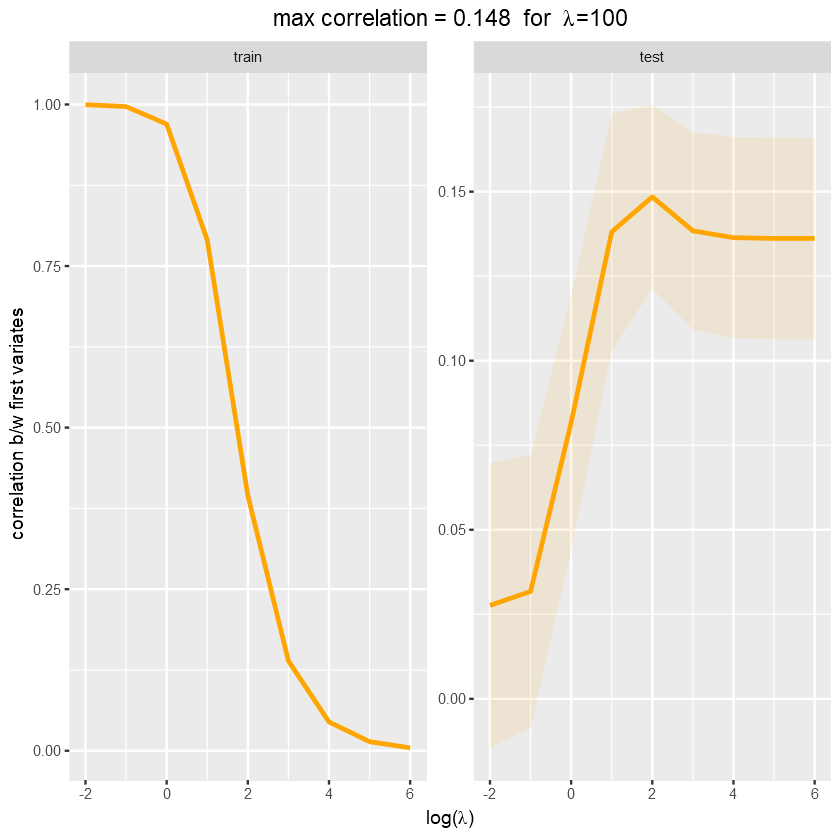

In [28]:
cor_first_test = subset(cor_first, set == 'test')
cor_opt = subset(cor_first_test, mean == max(cor_first_test$mean))
lambda1_opt = cor_opt$lambda1
cor_opt = cor_opt$mean

ggplot(cor_first, aes(x = log(lambda1, 10), y = mean)) +
geom_ribbon(aes(ymin = mean - se, ymax = mean + se), alpha = 0.1, color = NA, fill = "orange")+
geom_line(size = 1,  color = "orange")+
facet_wrap(~set, scale = "free")+
xlab(bquote(paste('log(', lambda, ')', sep = '')))+
ylab('correlation b/w first variates')+
guides(fill = FALSE)+
theme(plot.title = element_text(hjust = 0.5))+
ggtitle(bquote(paste('max correlation = ', .(round(cor_opt,3)), '  for  ', lambda, '=', .(lambda1_opt))))
ggsave(file = paste('Results/', task, '/RCCA/grid_search_first_cor.png', sep = ''), device = 'png', width = 10, height = 5)

## Calculate RCCA for the best lambda

In [29]:
RCCA = function(X, Y, lambda1){
    SVD = svd(X)
    R = SVD$u %*% diag(SVD$d)
    V = SVD$v
    rownames(V) = colnames(X)
    Crr = var(R, na.rm = TRUE, use = "pairwise") + diag(lambda1, ncol(R))
    Cyy = var(Y, na.rm = TRUE, use = "pairwise")
    Cry = cov(R, Y, use = "pairwise")
    RCCA = geigen(Cry, Crr, Cyy)
    names(RCCA) = c("cor", "xcoef", "ycoef")
    RCCA$xcoef = V %*% RCCA$xcoef
    return(list(cor = RCCA$cor, xcoef = RCCA$xcoef, ycoef = RCCA$ycoef))
}

In [30]:
best = RCCA(as.matrix(c_train), as.matrix(q_train), lambda1_opt)

Save the loadings. 

In [31]:
alpha = best$xcoef
colnames(alpha) = paste('RCCA', 1:ncol(alpha), sep = '')
beta = best$ycoef
colnames(beta) = paste('RCCA', 1:ncol(beta), sep = '')
write.csv(alpha, file = paste('Results/', task, '/RCCA/alpha.csv', sep = ''), row.names = TRUE)
write.csv(beta, file = paste('Results/', task, '/RCCA/beta.csv', sep = ''), row.names = TRUE)

Save scores train.

In [32]:
brain_scores = as.matrix(c_train)%*%as.matrix(alpha)
write.csv(brain_scores, file = paste('Results/', task, '/RCCA/brain_scores_train.csv', sep = ''), row.names = TRUE)
questionnaire_scores = as.matrix(q_train)%*%as.matrix(beta)
write.csv(questionnaire_scores, file = paste('Results/', task, '/RCCA/questionnaire_scores_train.csv', sep = ''), row.names = TRUE)
cors = diag(cor(brain_scores, questionnaire_scores))
write.csv(data.frame(t(cors)), file = paste('Results/', task, '/RCCA/correlation_train.csv', sep = ''), row.names = FALSE)

Save scores test.

In [33]:
brain_scores = as.matrix(c_test)%*%as.matrix(alpha)
write.csv(brain_scores, file = paste('Results/', task, '/RCCA/brain_scores_test.csv', sep = ''), row.names = TRUE)
questionnaire_scores = as.matrix(q_test)%*%as.matrix(beta)
write.csv(questionnaire_scores, file = paste('Results/', task, '/RCCA/questionnaire_scores_test.csv', sep = ''), row.names = TRUE)
cors = diag(cor(brain_scores, questionnaire_scores))
write.csv(data.frame(t(cors)), file = paste('Results/', task, '/RCCA/correlation_test.csv', sep = ''), row.names = FALSE)

# <font color='blue'>Upload grouping</font> 

In [34]:
groups = read.table(paste('Data/Connectome/groups.csv', sep = ''), sep = ',', header = TRUE)
groups = groups$Network_abbreviation

Create region-to-region names

In [35]:
names = unique(groups)
n = length(names)
pairs = matrix(paste(rep(names, n), rep(names, rep(n, n)), sep = '_'), n, n)
name_pairs_u = pairs[upper.tri(pairs, diag = FALSE)]
name_pairs_l = t(pairs)[upper.tri(pairs, diag = FALSE)]
name_pairs_d = diag(pairs)

In [36]:
n = length(groups)
pairs = matrix(paste(rep(groups, n), rep(groups, rep(n, n)), sep = '_'), n, n)
pairs = pairs[upper.tri(pairs, diag = FALSE)]

In [37]:
pairs_c = matrix(paste('c', rep(1:n, n), rep(1:n, rep(n, n)), sep = '_'), n, n)
pairs_c = pairs_c[upper.tri(pairs_c, diag = FALSE)]

Delete dublicating pairs

In [38]:
levels = c(name_pairs_u, name_pairs_l, name_pairs_d) 
labels = c(name_pairs_u, name_pairs_u, name_pairs_d)
pairs_match = factor(pairs, levels = levels, labels = labels)

Save regions

In [39]:
write.csv(data.frame('Pair' = pairs_c, 'Region' = pairs_match), file = paste('Data/Connectome/region_to_region.csv', sep = ''), row.names = FALSE)

In [40]:
groups = pairs_match
c_train = c_train[, as.character(pairs_c)]
c_test = c_test[, as.character(pairs_c)]

# <font color='blue'>Cross-Validated Group RCCA</font>

In [41]:
library(CCA)

Warning message:
"package 'CCA' was built under R version 3.6.3"Loading required package: fields
Warning message:
"package 'fields' was built under R version 3.6.3"Loading required package: spam
Warning message:
"package 'spam' was built under R version 3.6.3"Loading required package: dotCall64
Spam version 2.5-1 (2019-12-12) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: 'spam'

The following object is masked from 'package:Matrix':

    det

The following objects are masked from 'package:base':

    backsolve, forwardsolve

Loading required package: maps
See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 


Splits the data in train (90%) and test (10%) at random and returns the canonical correlations for training and test data.
Calculate 1SD confidence intervals for train and test canonical correlations.

In [42]:
GRCCA_CV = function(X, Y, lambda1s, mu1s, groups, split){
    ncomp = ncol(Y)
    n = nrow(X)
    K = max(split)
    colnames(X) = groups
    cor_cv = c()
    group_names = unique(sort(groups))
    ngs = table(groups)
    agg = aggregate(t(X), by = list(groups), FUN = mean)
    Xmean = t(agg[, -1])
    colnames(Xmean) = agg[, 1]  
    for(mu1 in mu1s){
        for(lambda1 in lambda1s){
            nu = mu1/lambda1
            #create extended matrix
            Xextended = cbind(scale(Xmean[,group_names], center = FALSE, scale = sqrt(nu/ngs[group_names])), X - Xmean[,groups])
            #compute R and V for extended matrix
            SVD = svd(Xextended)
            R = SVD$u %*% diag(SVD$d)
            V = SVD$v
            rownames(V) = colnames(Xextended)
            cor_train = matrix(0, ncomp, K)
            cor_test = matrix(0, ncomp, K)
            colnames(cor_train) = paste('split', 1:K, sep = '')
            colnames(cor_test) = paste('split', 1:K, sep = '')
            #repeat split nreps times and save train and test correlations
            for(k in 1:K){
                #split the data into train and test
                ind_test = (split == k)
                ind_train = (split != k)
                #run RCCA
                Crr = var(R[ind_train, ], na.rm = TRUE, use = "pairwise") + diag(lambda1, ncol(R))
                Cyy = var(Y[ind_train, ], na.rm = TRUE, use = "pairwise")
                Cry = cov(R[ind_train, ], Y[ind_train, ], use = "pairwise")
                RCCA = geigen(Cry, Crr, Cyy)
                names(RCCA) = c("cor", "xcoef", "ycoef")
                #transform alpha to Xextended basis
                RCCA$xcoef = V %*% RCCA$xcoef
                #transform alpha to X basis
                alphaXmean = RCCA$xcoef[1:ncol(Xmean),]
                alphaXmean = t(scale(t(alphaXmean), center = FALSE, scale = sqrt(ngs[rownames(alphaXmean)] * nu)))
                alphaX = RCCA$xcoef[-(1:ncol(Xmean)),]
                alpha = alphaX + alphaXmean[groups,]
                beta = RCCA$ycoef
                #compute train and test correlation
                cor_train[,k] = RCCA$cor
                cor_test[,k] = diag(cor(X[ind_test, ]%*%alpha, Y[ind_test, ]%*%beta))
            }
            cor_cv = rbind(cor_cv, data.frame(cor_train, 'comp' = 1:ncomp, 'set' = 'train', 'lambda1' = lambda1, 'mu1' = mu1), 
                             data.frame(cor_test, 'comp' = 1:ncomp, 'set' = 'test', 'lambda1' = lambda1, 'mu1' = mu1))
        }
    }
    return(cor_cv)
}

## Run grid search for GRCCA

Vary $\lambda_1$ and $\nu$ and compute GRCCA.

In [43]:
mu1s = 10^seq(-4,4)
lambda1s = 10^seq(-4,4)

cor_cv = GRCCA_CV(c_train, q_train, lambda1s, mu1s, groups, split_train)
write.csv(cor_cv, file = paste('Results/', task, '/GRCCA/correlation_train_cv.csv', sep = ''), row.names = FALSE)

## First correlation plot

In [44]:
cor_cv = read.table(file = paste('Results/', task, '/GRCCA/correlation_train_cv.csv', sep = ''), sep = ',', header = TRUE) 

Average correlation across splits.

In [45]:
cor_first = subset(cor_cv, comp == 1)
cor_mean = apply(subset(cor_first,  select = -c(lambda1, mu1, set, comp)), 1, mean)
cor_sd = apply(subset(cor_first, select = -c(lambda1, mu1, set, comp)), 1, sd)
cor_first = cbind('mean' = cor_mean, 'se' = cor_sd/sqrt(K), subset(cor_first, select = c(lambda1, mu1, set, comp))) 
cor_first$set = factor(cor_first$set, levels = c('train', 'test'))

Plot correlation.

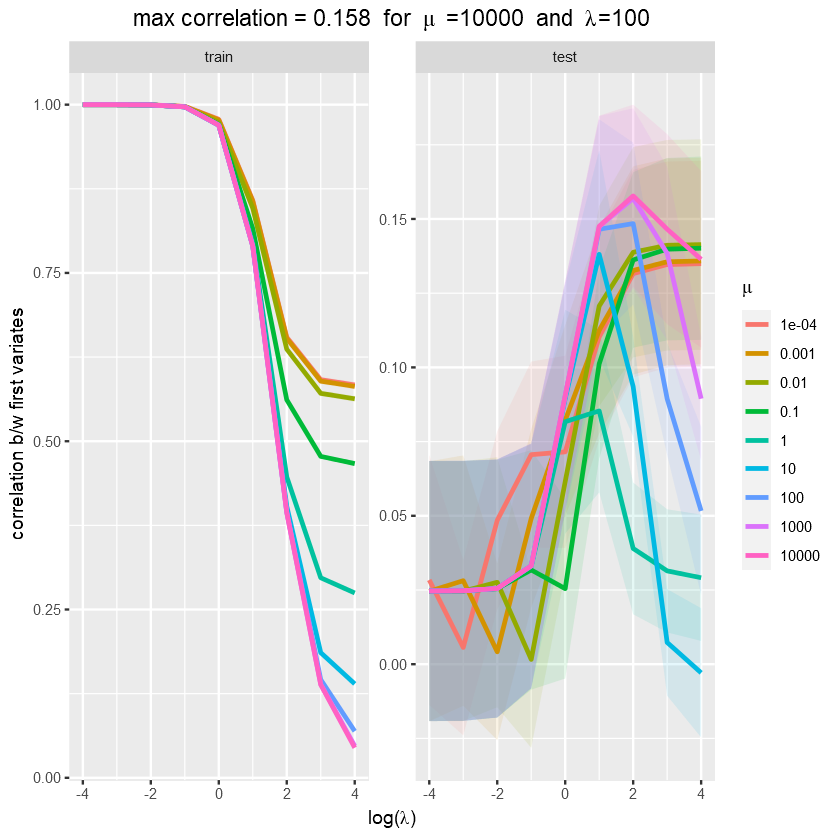

In [46]:
cor_first_test = subset(cor_first, set == 'test')
cor_opt = subset(cor_first_test, mean == max(cor_first_test$mean))
lambda1_opt = cor_opt$lambda1
mu1_opt = cor_opt$mu1
cor_opt = cor_opt$mean

ggplot(cor_first, aes(x = log(lambda1, 10), y = mean,  color = factor(mu1), fill = factor(mu1))) +
geom_ribbon(aes(ymin = mean - se, ymax = mean + se), alpha = 0.1, color = NA)+
geom_line(size = 1)+
facet_wrap(~set, scale = "free")+
xlab(bquote(paste('log(', lambda, ')', sep = '')))+
ylab('correlation b/w first variates')+
labs(color = bquote(mu))+
guides(fill = FALSE)+
theme(plot.title = element_text(hjust = 0.5))+
ggtitle(bquote(paste('max correlation = ', .(round(cor_opt,3)), '  for  ', mu, '=' , .(mu1_opt), '  and  ', lambda, '=', .(lambda1_opt))))
ggsave(file = paste('Results/', task, '/GRCCA/grid_search_first_cor.png', sep = ''), device = 'png', width = 10, height = 5)

## Calculate GRCCA for the best hyperparameters

In [47]:
GRCCA = function(X, Y, lambda1, mu1, groups){
    nu = mu1/lambda1
    colnames(X) = groups
    group_names = unique(sort(groups))
    ngs = table(groups)
    agg = aggregate(t(X), by = list(groups), FUN = mean)
    Xmean = t(agg[, -1])
    colnames(Xmean) = agg[, 1]
    Xextended = cbind(scale(Xmean[,group_names], center = FALSE, scale =  sqrt(nu/ngs[group_names])), X - Xmean[,groups])
    SVD = svd(Xextended)
    R = SVD$u %*% diag(SVD$d)
    V = SVD$v
    rownames(V) = colnames(Xextended)
    Cxx = var(R, na.rm = TRUE, use = "pairwise") + diag(lambda1, ncol(R))
    Cyy = var(Y, na.rm = TRUE, use = "pairwise")
    Cxy = cov(R, Y, use = "pairwise")
    res = geigen(Cxy, Cxx, Cyy)
    names(res) = c("cor", "xcoef", "ycoef")
    res$xcoef = V %*% res$xcoef
    alpha0 = res$xcoef[1:ncol(Xmean),]
    alpha0 = t(scale(t(alpha0), center = FALSE, scale = sqrt(ngs[rownames(alpha0)] * nu) ))
    alpha = res$xcoef[-(1:ncol(Xmean)),]
    res$xcoef = alpha + alpha0[groups,]    
    return(list(cor = res$cor, xcoef = res$xcoef, ycoef = res$ycoef))
}

In [48]:
best = GRCCA(as.matrix(c_train), as.matrix(q_train), lambda1_opt, mu1_opt, groups)

Save the loadings. 

In [49]:
alpha = best$xcoef
colnames(alpha) = paste('GRCCA', 1:ncol(alpha), sep = '')
beta = best$ycoef
colnames(beta) = paste('GRCCA', 1:ncol(beta), sep = '')
write.csv(alpha, file = paste('Results/', task, '/GRCCA/alpha.csv', sep = ''), row.names = TRUE)
write.csv(beta, file = paste('Results/', task, '/GRCCA/beta.csv', sep = ''), row.names = TRUE)

Save scores train.

In [50]:
brain_scores = as.matrix(c_train)%*%as.matrix(alpha)
write.csv(brain_scores, file = paste('Results/', task, '/GRCCA/brain_scores_train.csv', sep = ''), row.names = TRUE)
questionnaire_scores = as.matrix(q_train)%*%as.matrix(beta)
write.csv(questionnaire_scores, file = paste('Results/', task, '/GRCCA/questionnaire_scores_train.csv', sep = ''), row.names = TRUE)
cors = diag(cor(brain_scores, questionnaire_scores))
write.csv(data.frame(t(cors)), file = paste('Results/', task, '/GRCCA/correlation_train.csv', sep = ''), row.names = FALSE)

Save scores test.

In [51]:
brain_scores = as.matrix(c_test)%*%as.matrix(alpha)
write.csv(brain_scores, file = paste('Results/', task, '/GRCCA/brain_scores_test.csv', sep = ''), row.names = TRUE)
questionnaire_scores = as.matrix(q_test)%*%as.matrix(beta)
write.csv(questionnaire_scores, file = paste('Results/', task, '/GRCCA/questionnaire_scores_test.csv', sep = ''), row.names = TRUE)
cors = diag(cor(brain_scores, questionnaire_scores))
write.csv(data.frame(t(cors)), file = paste('Results/', task, '/GRCCA/correlation_test.csv', sep = ''), row.names = FALSE)

# <font color='blue'>Permutation test</font>

Shuffle the rows of the data, then compute test correlation between the first variates and test angle between canonical subspaces. Repeat *n_perm* times.

In [52]:
GRCCA_perm = function(X, Y, X_val, Y_val, lambda1, mu1, groups, n_perm){
    set.seed(0)
    cor_perm = numeric(n_perm)
    angle_perm = numeric(n_perm)
    nu = mu1/lambda1
    colnames(X) = groups
    group_names = unique(sort(groups))
    ngs = table(groups)
    agg = aggregate(t(X), by = list(groups), FUN = mean)
    Xmean = t(agg[, -1])
    colnames(Xmean) = agg[, 1]
    Xextended = cbind(scale(Xmean[,group_names], center = FALSE, scale =  sqrt(nu/ngs[group_names])), X - Xmean[,groups])
    SVD = svd(Xextended)
    R = SVD$u %*% diag(SVD$d)
    V = SVD$v
    rownames(V) = colnames(Xextended)
    Cxx = var(R, na.rm = TRUE, use = "pairwise") + diag(lambda1, ncol(R))
    index = 1:nrow(X)
    for(i in 1:n_perm){
        Y_perm = Y[index,]
        Cyy = var(Y_perm, na.rm = TRUE, use = "pairwise")
        Cxy = cov(R, Y_perm, use = "pairwise")
        res = geigen(Cxy, Cxx, Cyy)
        names(res) = c("cor", "xcoef", "ycoef")
        res$xcoef = V %*% res$xcoef
        alpha0 = res$xcoef[1:ncol(Xmean),]
        alpha0 = t(scale(t(alpha0), center = FALSE, scale = sqrt(ngs[rownames(alpha0)] * nu) ))
        alpha = res$xcoef[-(1:ncol(Xmean)),]
        res$xcoef = alpha + alpha0[groups,]    
        X_scores = X_val%*%res$xcoef
        Y_scores = Y_val%*%res$ycoef
        cor_perm[i] = diag(cor(X_scores, Y_scores))[1]
        angle_perm[i] = cc(X_scores, Y_scores)$cor[1]
        index = sample(1:nrow(X))
    } 
    return(list(cor_perm = cor_perm, angle_perm = angle_perm))
}

Save the result.

In [53]:
permute = GRCCA_perm(as.matrix(c_train), as.matrix(q_train), as.matrix(c_test), as.matrix(q_test), lambda1_opt, mu1_opt, groups, 1000)
write.csv(data.frame('null_cor' = permute$cor_perm), file = paste('Results/', task, '/GRCCA/null_distribution_correlation_test.csv', sep = ''), row.names = FALSE)
write.csv(data.frame('null_cor' = permute$angle_perm), file = paste('Results/', task, '/GRCCA/null_distribution_angle_test.csv', sep = ''), row.names = FALSE)

Plot the distribution, position the actual value and compute the p-value

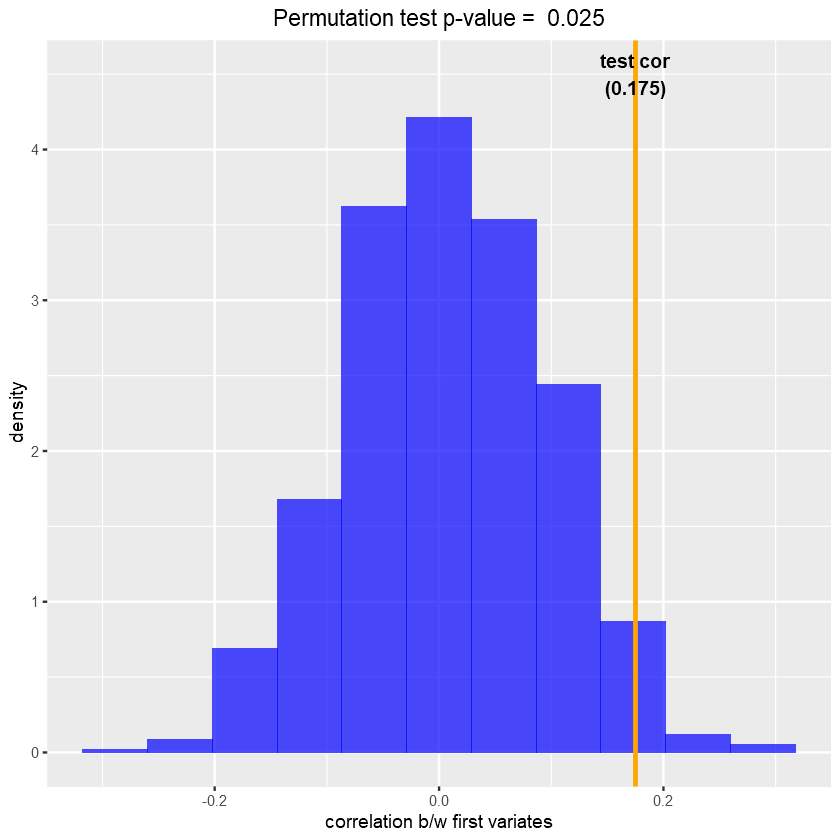

In [54]:
cor_test = permute$cor_perm[1]
ggplot()+
geom_histogram(aes(x = permute$cor_perm, y = ..density..), bins = 11, alpha = 0.7, fill = "blue")+
geom_vline(aes(xintercept = cor_test), color = 'orange', size = 1)+
geom_text(aes(x = cor_test, y = 4.5, label = paste('test cor\n(', round(cor_test,3), ')', sep = '')), size = 4, fontface = 'bold')+
ggtitle(paste('Permutation test p-value = ', mean(permute$cor_perm > cor_test)))+
theme(plot.title = element_text(hjust = 0.5)) + xlab('correlation b/w first variates')
ggsave(paste('Results/', task, '/GRCCA/permutation_correlation_test.png', sep = ''),  device = 'png', width = 6, height = 6)

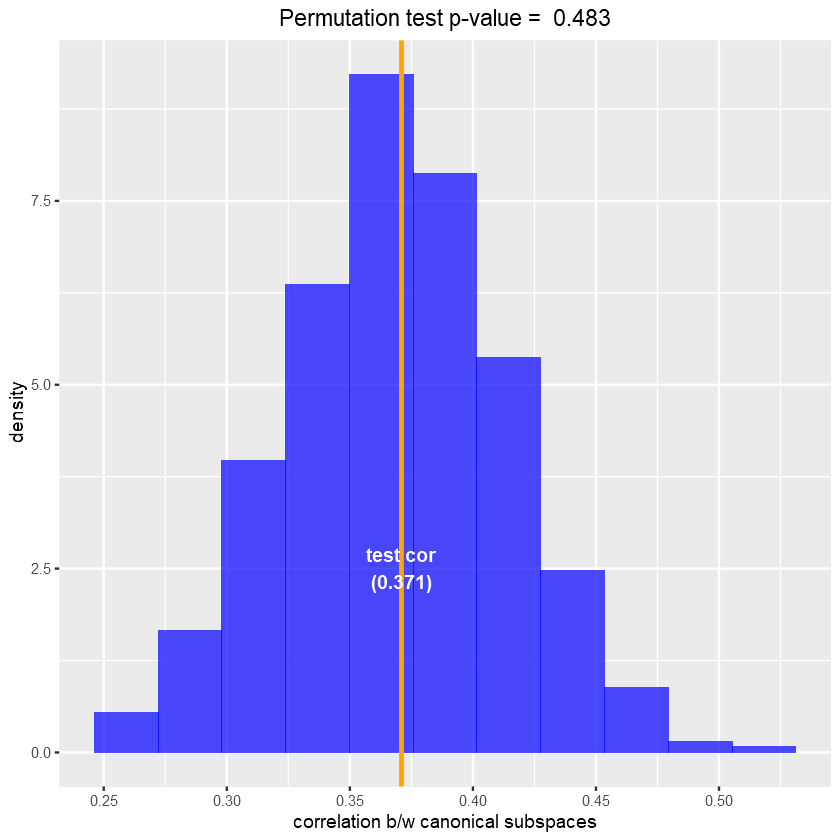

In [55]:
angle_test = permute$angle_perm[1]
ggplot()+
geom_histogram(aes(x = permute$angle_perm, y = ..density..), bins = 11, alpha = 0.7, fill = "blue")+
geom_vline(aes(xintercept = angle_test), color = 'orange', size = 1)+
geom_text(aes(x = angle_test, y = 2.5, label = paste('test cor\n(', round(angle_test, 3), ')', sep = '')), color = 'white', size = 4, fontface = 'bold')+
ggtitle(paste('Permutation test p-value = ', mean(permute$angle_perm > angle_test)))+
theme(plot.title = element_text(hjust = 0.5)) + xlab('correlation b/w canonical subspaces')
ggsave(paste('Results/', task, '/GRCCA/permutation_angle_test.png', sep = ''),  device = 'png', width = 6, height = 6)